<a href="https://colab.research.google.com/github/ankit1997/implementing_papers/blob/master/Image_segmentation_using_GAN_Github_Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.modules.loss as loss
import torch.optim as optim
from torchvision import transforms, utils
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader

In [0]:
import random
import numpy as np
from PIL import Image
from itertools import chain
from collections import Counter
import matplotlib.pyplot as plt

In [83]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(609, 609) uint8
Most common values: [53, 82, 145, 220, 255]
New values in referece image: [0 1 2 3 4]


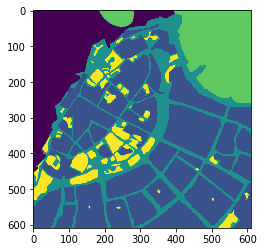

# Converting to categorical
Reference output shape: (609, 609, 5)


In [85]:
ref_img = Image.open('drive/My Drive/Reference.tif')
reference_output = np.asarray(ref_img.getchannel(0))
print(reference_output.shape, reference_output.dtype)
# plt.imshow(reference_output)
# plt.show()

HEIGHT, WIDTH = reference_output.shape
NUM_CLASSES = 5

# find most common colors in reference output
counter = Counter(reference_output.flatten().tolist())
most_common = counter.most_common(NUM_CLASSES)
most_common = [mc[0] for mc in most_common]
most_common.sort()
print('Most common values: {}'.format(most_common))

# find nearest value in `most_common` and replace with index
def to_nearest_in_list(element):
    min_dist = 10000.0
    nearest_num = -1
    for i, num in enumerate(most_common):
        dist = abs(num - element)
        if dist < min_dist:
            min_dist = dist
            nearest_num = i
    return nearest_num

to_nearest_np = np.vectorize(to_nearest_in_list)
reference_output = to_nearest_np(reference_output)

print('New values in referece image: {}'.format(np.unique(reference_output)))

plt.imshow(reference_output)
plt.show()

print('# Converting to categorical')

# convert to categorical
to_categorial = lambda array, num_classes: np.eye(num_classes, dtype=np.uint8)[array]
reference_out_categorical = to_categorial(reference_output, NUM_CLASSES)

print('Reference output shape: {}'.format(reference_out_categorical.shape))


(609, 609) uint8


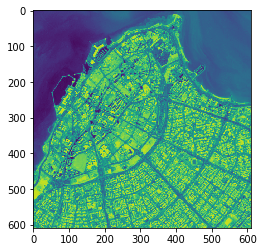

In [118]:
input_image = np.asarray(Image.open('drive/My Drive/Input.tif'))
print(input_image.shape, input_image.dtype)
plt.imshow(input_image)

In [0]:
SAMPLE_HEIGHT = SAMPLE_WIDTH = 300
BATCHS_SIZE = 4
RANDOM_SEED = 17
ITERATIONS = 10000

# function to convert categorical to image
to_image = lambda categorical, axis: np.argmax(categorical, axis=axis)

class LandDataset(Dataset):
    def __init__(self, Img, Ref):
        self.img = Img
        self.ref = Ref
        
        assert self.img.shape == (HEIGHT, WIDTH)
        assert self.ref.shape == (HEIGHT, WIDTH, NUM_CLASSES)
    
    def __len__(self):
        return ITERATIONS
    
    def __getitem__(self, _):
        start_i = (torch.rand(1) * (HEIGHT - SAMPLE_HEIGHT)).int()
        start_j = (torch.rand(1) * (WIDTH - SAMPLE_WIDTH)).int()
        # start_i = random.randrange(0, HEIGHT-SAMPLE_HEIGHT)
        # start_j = random.randrange(0, WIDTH-SAMPLE_WIDTH)
        
        inp = torch.from_numpy(self.img[start_i: start_i+SAMPLE_HEIGHT, start_j: start_j+SAMPLE_WIDTH])
        inp = inp.unsqueeze(-1)
        inp = inp.transpose(0, 2)
        # print(inp.shape) # [1, 300, 300]
        
        out = torch.from_numpy(self.ref[start_i: start_i+SAMPLE_HEIGHT, start_j: start_j+SAMPLE_WIDTH, :])
        out = out.transpose(0, 2)
        # print(out.shape) # [5, 300, 300]
        
        return {
            'input': inp.float().to(device),
            'output': out.float().to(device)
        }

Input shape: torch.Size([4, 1, 300, 300])
Output shape: torch.Size([4, 5, 300, 300])


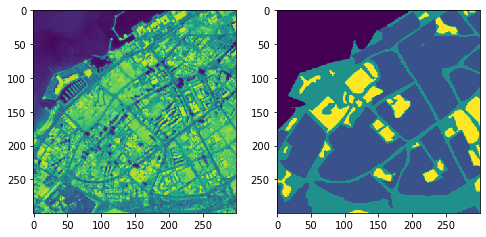

In [120]:
dataset = LandDataset(input_image, reference_out_categorical)
dataLoader = DataLoader(dataset, batch_size=BATCHS_SIZE, shuffle=True)

for data in dataLoader:
    sample_datapoint = data
    print('Input shape: {}'.format(sample_datapoint['input'].shape))
    print('Output shape: {}'.format(sample_datapoint['output'].shape))
    sample_datapoint['input'] = sample_datapoint['input'][0]
    sample_datapoint['output'] = sample_datapoint['output'][0]
    break

plt.figure(figsize=(8, 6))
plt.subplot(121)
plt.imshow(torch.squeeze(sample_datapoint['input'].cpu()))
plt.subplot(122)
plt.imshow(to_image(sample_datapoint['output'].cpu(), 0))
plt.show()

In [0]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        
        self.dconv1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3)
        self.dconv2 = nn.ConvTranspose2d(in_channels=32, out_channels=NUM_CLASSES, kernel_size=3)
        
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        
        activation = F.relu
        
        x = self.conv1(x)
        x = activation(x)
        
        x = self.conv2(x)
        x = activation(x)
        
        x = self.dconv1(x)
        x = activation(x)
        
        x = self.dconv2(x)
        x = activation(x)
        x = self.softmax(x)
        
        # print('output of Segmentor model: {}'.format(x.shape))
        # [BATCH_SIZE, NUM_CLASSES, SAMPLE_HEIGHT, SAMPLE_WIDTH]
        
        return x

In [0]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1_i = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
        self.conv2_i = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3)
        
        self.conv1_o = nn.Conv2d(in_channels=NUM_CLASSES, out_channels=8, kernel_size=3)
        self.conv2_o = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3)
        
        self.conv1_c = nn.Conv2d(in_channels=64, out_channels=8, kernel_size=3)
        self.conv2_c = nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3)
        
        self.dense1 = nn.Linear(in_features=28*28, out_features=2)
        
        self.maxpool = nn.MaxPool2d(3)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, img, seg):
        
        activation = F.relu
        
        x1 = img
        x2 = seg
        
        x1 = self.conv1_i(x1)
        x1 = activation(x1)
        x1 = self.maxpool(x1)
        
        x1 = self.conv2_i(x1)
        x1 = activation(x1)
        x1 = self.maxpool(x1)
        
        x2 = self.conv1_o(x2)
        x2 = activation(x2)
        x2 = self.maxpool(x2)
        
        x2 = self.conv2_o(x2)
        x2 = activation(x2)
        x2 = self.maxpool(x2)
        
        concat = torch.cat([x1, x2], dim=1)
        
        c = self.conv1_c(concat)
        c = activation(c)
        
        c = self.conv2_c(c)
        c = activation(c)

        c = c.squeeze()
        c = c.view(c.shape[0], -1)
        
        c = self.dense1(c)
        c = activation(c)
        c = self.softmax(c)
        
        # print(c.shape)

        return c

In [0]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

loss_function = nn.BCELoss()
loss_Gs = []
loss_Ds = []

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(discriminator.parameters(), lr=0.0001)
optimizerG = optim.Adam(generator.parameters(), lr=0.0001)

In [0]:
for data in dataLoader:
    discriminator(torch.rand(4, 1, 300, 300).to(device), torch.rand(4, 5, 300, 300).to(device))
    break

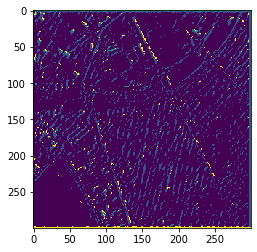

D: 1.3862965106964111, G: 0.6931481957435608


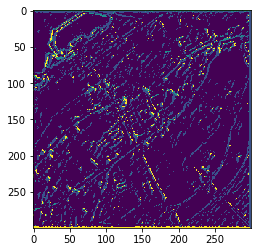

D: 1.3863210678100586, G: 0.6931601762771606


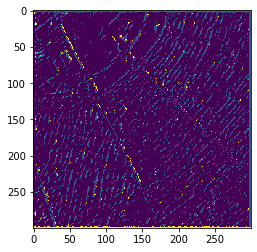

D: 1.3863002061843872, G: 0.6931500434875488


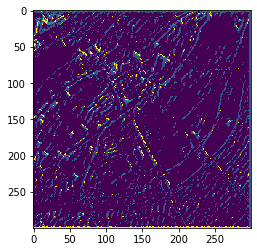

D: 1.3862979412078857, G: 0.6931489706039429


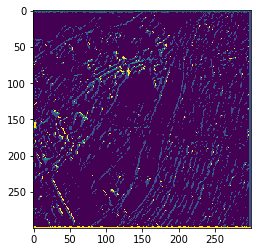

D: 1.3862943649291992, G: 0.6931471824645996


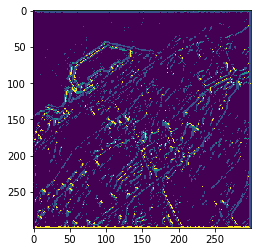

D: 1.3862961530685425, G: 0.6931480765342712


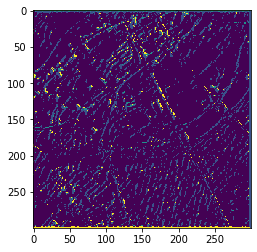

D: 1.3862943649291992, G: 0.6931472420692444


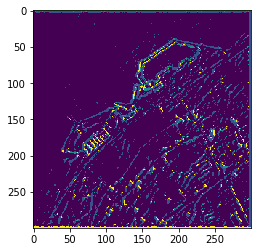

D: 1.3864003419876099, G: 0.6931979656219482


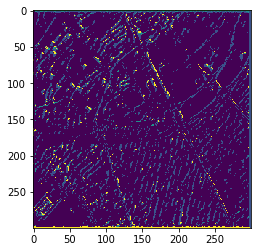

D: 1.3862946033477783, G: 0.6931472420692444


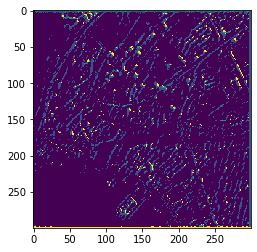

D: 1.3862948417663574, G: 0.6931474208831787


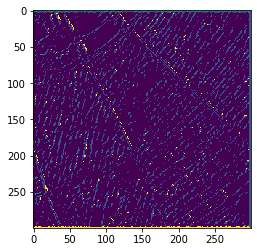

D: 1.3862943649291992, G: 0.6931472420692444


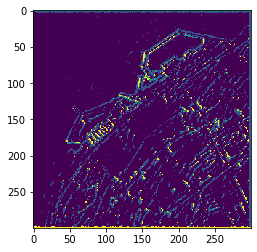

D: 1.3862946033477783, G: 0.6931473016738892


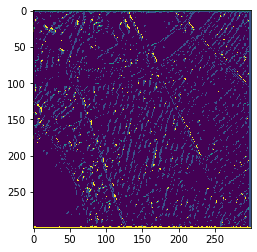

D: 1.3862944841384888, G: 0.6931472420692444


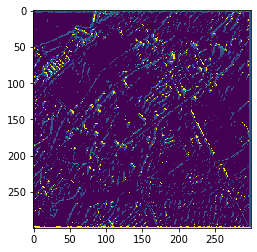

D: 1.3862953186035156, G: 0.6931476593017578


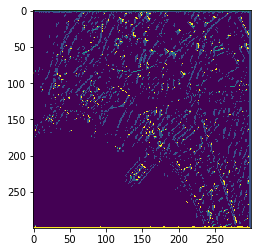

D: 1.3862953186035156, G: 0.6931476593017578


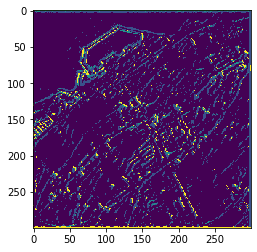

D: 1.3862943649291992, G: 0.6931471824645996


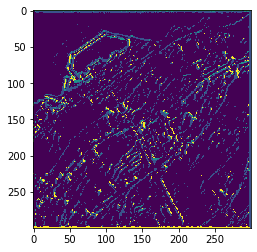

D: 1.386295199394226, G: 0.6931476593017578


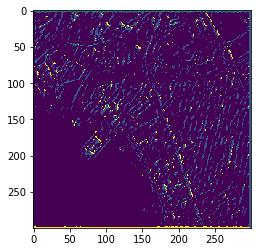

D: 1.3862992525100708, G: 0.6931495666503906


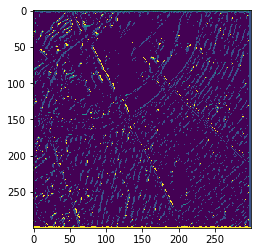

D: 1.3863002061843872, G: 0.6931501626968384


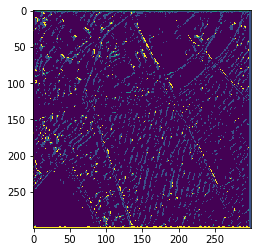

D: 1.3862943649291992, G: 0.6931471824645996


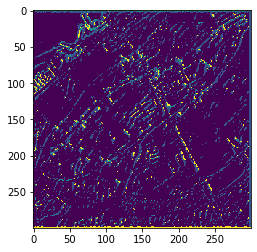

D: 1.3862969875335693, G: 0.6931484937667847


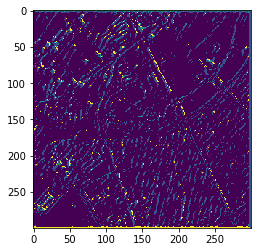

D: 1.3863013982772827, G: 0.6931507587432861


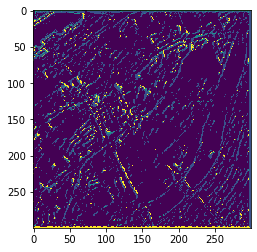

D: 1.3863368034362793, G: 0.6931682825088501


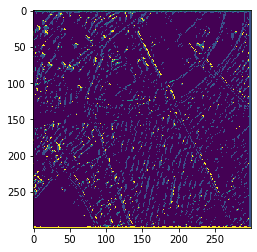

D: 1.3862943649291992, G: 0.6931471824645996


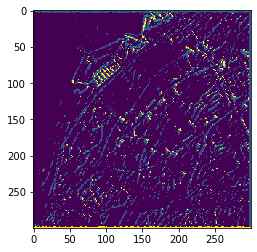

D: 1.3862943649291992, G: 0.6931471824645996


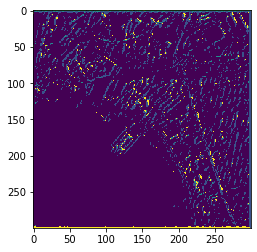

D: 1.386296033859253, G: 0.6931480169296265


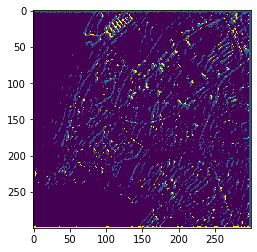

D: 1.386297345161438, G: 0.6931486129760742


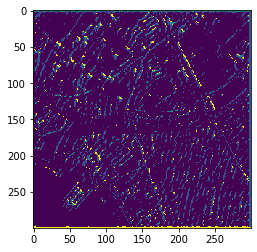

D: 1.3862943649291992, G: 0.6931472420692444


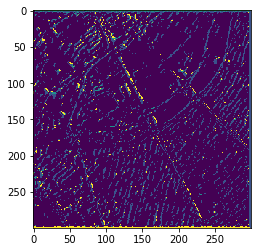

D: 1.3862943649291992, G: 0.6931472420692444


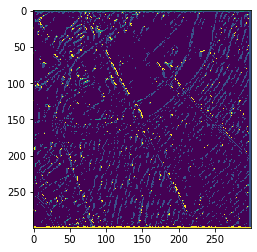

D: 1.3863273859024048, G: 0.6931635141372681


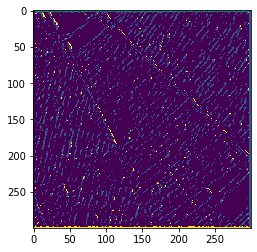

D: 1.3862943649291992, G: 0.6931471824645996


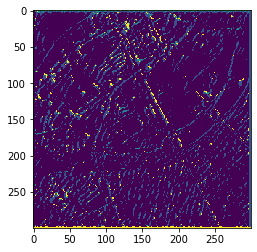

D: 1.3862950801849365, G: 0.6931475400924683


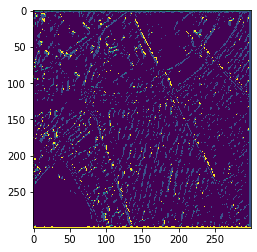

D: 1.3862944841384888, G: 0.6931472420692444


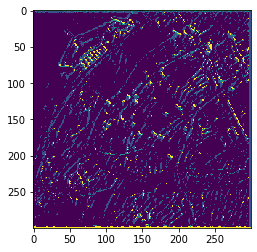

D: 1.3862981796264648, G: 0.6931489706039429


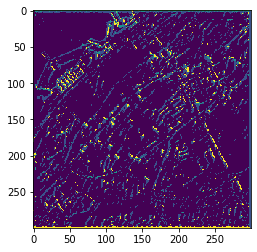

D: 1.3862946033477783, G: 0.6931473016738892


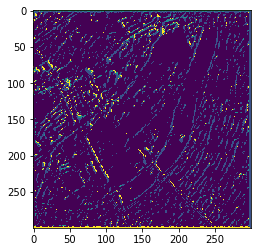

D: 1.3862943649291992, G: 0.6931471824645996


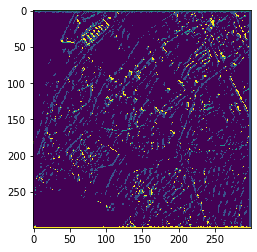

D: 1.3862953186035156, G: 0.6931476593017578


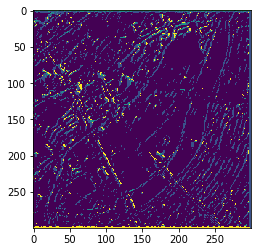

D: 1.3862943649291992, G: 0.6931471824645996


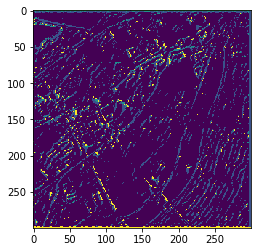

D: 1.3862943649291992, G: 0.6931471824645996


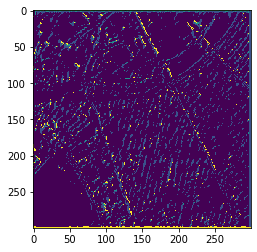

D: 1.3862943649291992, G: 0.6931471824645996


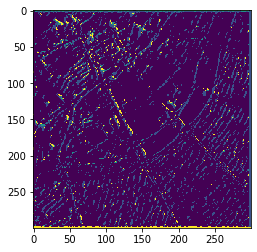

D: 1.3862946033477783, G: 0.6931473016738892


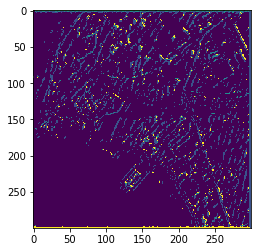

D: 1.3862943649291992, G: 0.6931471824645996


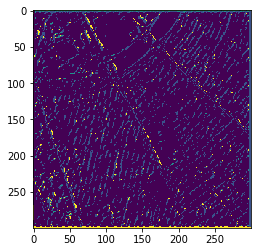

D: 1.3862943649291992, G: 0.6931471824645996


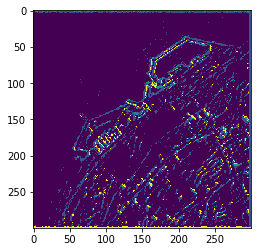

D: 1.386317491531372, G: 0.6931581497192383


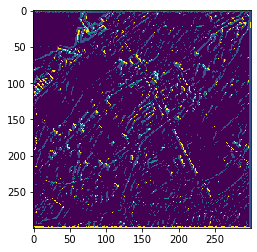

D: 1.3862959146499634, G: 0.6931478977203369


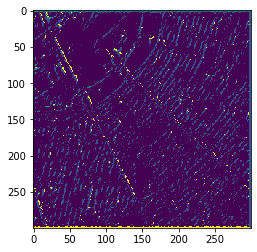

D: 1.3862943649291992, G: 0.6931471824645996


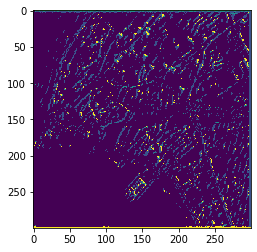

D: 1.3862946033477783, G: 0.6931473016738892


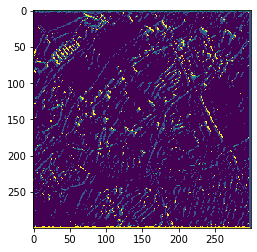

D: 1.3862972259521484, G: 0.6931484937667847


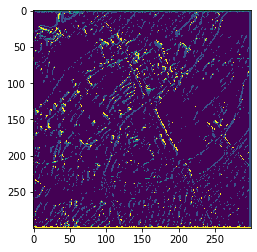

D: 1.3862947225570679, G: 0.6931473612785339


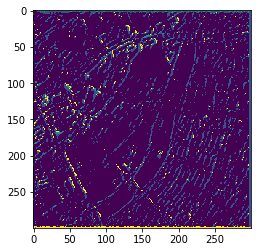

D: 1.386350393295288, G: 0.6931737661361694


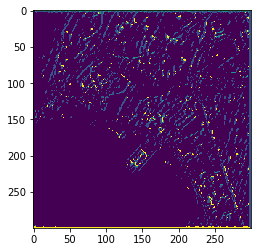

D: 1.3862943649291992, G: 0.6931471824645996


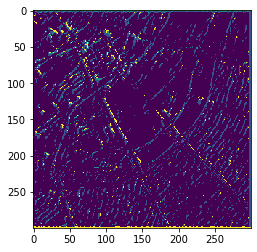

D: 1.3862943649291992, G: 0.6931471824645996


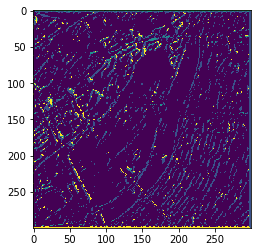

D: 1.38631272315979, G: 0.6931561231613159


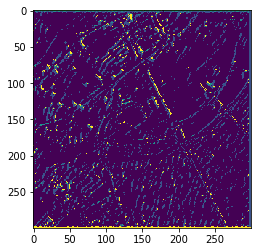

D: 1.3862954378128052, G: 0.6931476593017578


KeyboardInterrupt: ignored

In [177]:
for i, data in enumerate(dataLoader):
    
    x = data['input']
    real = data['output']

    # plt.imshow(x.cpu().numpy()[0, 0, :, :])
    # plt.show()
    # plt.imshow(np.argmax(real.cpu().numpy(), axis=1)[0, :, :])
    # plt.show()

    discriminator.zero_grad()
    
    # all real batch
    label = torch.full((BATCHS_SIZE, 2), real_label).to(device)
    output = discriminator(x, real)
    
    loss_real = loss_function(output, label)
    loss_real.backward()
    D_x = output.mean().item()
    
    # all fake batch
    label.fill_(fake_label)
    fake = generator(x)
    plt.imshow(np.argmax(fake.detach().cpu().numpy(), axis=1)[0, :, :])
    plt.show()
    output = discriminator(x, fake.detach())
    
    loss_fake = loss_function(output, label)
    loss_fake.backward()
    D_Gx1 = output.mean().item()
    
    loss_D = loss_real + loss_fake
    optimizerD.step()
    
    
    generator.zero_grad()
    label.fill_(real_label)
    output = discriminator(x, fake)
    
    loss_G = loss_function(output, label)
    loss_G.backward()
    D_Gx2 = output.mean().item()
    optimizerG.step()

    loss_Gs.append(loss_G.item())
    loss_Ds.append(loss_D.item())
    
    

    
    # print('G: {} D_real: {} D_fake: {}'.format(D_Gx2, D_x, D_Gx1))
    print('D: {}, G: {}'.format(loss_D.item(), loss_G.item()))
    
    if i == 1000:
        break

In [71]:
fake.shape

torch.Size([4, 5, 300, 300])

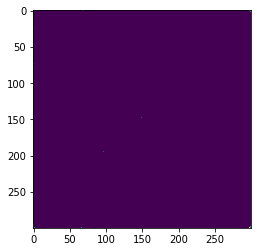

In [125]:
plt.imshow(np.argmax(fake.cpu().detach().numpy(), axis=1)[0, :, :])

In [66]:
np.count_nonzero(np.argmax(fake.cpu().detach().numpy(), axis=1)[0, :, :] == 1)

299

In [148]:
pytorch_total_params = sum(p.numel() for p in generator.parameters() if p.requires_grad)
print(pytorch_total_params)

38725
